In [1]:
from user_ops import ft_pool
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import math
import pickle

import os
import sys
sys.path.append(os.path.join('..', '..', 'keras_frac'))
from fractional_maxpooling import FractionalPooling2D

%matplotlib inline

init = "he_uniform"

/opt/miniconda3/envs/tf1_13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/tf1_13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/tf1_13/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/tf1_13/lib/python3.7/site-packages/tensorflow/

In [2]:
class max_pool_net:
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
    
    def train(self, batch_size, epochs, datagen=None, train_data=None, callbacks=None):
        if datagen is None and train_data is None:
            print('neither data or generator was passed')
        elif datagen is None and train_data is not None:
            print('training on array data, network type:', type(self).__name__)
            self.history = self.model.fit(x = train_data[0], y = train_data[1], validation_data=train_data[2:], batch_size=batch_size, epochs=epochs, callbacks=callbacks)
        else:
            print('training on datagen data, network type:', type(self).__name__)
            self.history = self.model.fit_generator(datagen, validation_data=train_data[2:], batch_size=batch_size, epochs=epochs, callbacks=callbacks)
        self.weights = self.model.get_weights()
    
    def restart_session(self):
        keras.backend.clear_session()
        
    def get_history(self):
        return self.history
    
    def get_weights(self):
        return self.weights
    
    def load_weights(self):
        self.model.load_weights(self.weights)

        
class frac_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        ratio = 1.35 # 1.33 blocks=3
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
    
    
class ft_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        strides=(math.sqrt(2), math.sqrt(2))
        pool_size=(math.sqrt(2)*2, math.sqrt(2)*2)
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
        
class avg_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        pool_size=2
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(2,2), padding='same'))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(2,2), padding='same'))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())

In [3]:
EPOCHS = 30
BATCH_SIZE = 100
iter = 10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [4]:
ft_net_h = []
path = os.path.join('results', 'mine_widthout_div')
for _ in range(iter):
    ft_net = ft_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    ft_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    ft_net_h.append([ft_net.get_history().history['accuracy'], ft_net.get_history().history['val_accuracy']])
    ft_net.restart_session()
with open(os.path.join(path,'ft_net_h.pkl'), 'wb') as f:
    pickle.dump(ft_net_h, f)

avg_net_h = []
for _ in range(iter):
    avg_net = avg_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    avg_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    avg_net_h.append([avg_net.get_history().history['accuracy'], avg_net.get_history().history['val_accuracy']])
    avg_net.restart_session()
with open(os.path.join(path,'avg_net_h.pkl'), 'wb') as f:
    pickle.dump(avg_net_h, f)

max_net_h = []
for _ in range(iter):
    max_net = max_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    max_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    max_net_h.append([max_net.get_history().history['accuracy'], max_net.get_history().history['val_accuracy']])
    max_net.restart_session()
with open(os.path.join(path,'max_net_h.pkl')) as f:
    pickle.dump(max_net_h, f)

frac_net_h = []
for _ in range(iter):
    frac_net = frac_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    frac_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    frac_net_h.append([frac_net.get_history().history['accuracy'], frac_net.get_history().history['val_accuracy']])
    frac_net.restart_session()
with open(os.path.join(path,'frac_net_h.pkl'), 'wb') as f:
    pickle.dump(frac_net_h, f)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
_________________________________________________________________
lambda_1 (Lambda)            (100, 23, 23, 2)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 23, 23, 2)          38        
_________________________________________________________________
lambda_2 (Lambda)            (100, 16, 16, 2)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 16, 16, 4)          76        
_________________________________________________________________
lambda_3 (Lambda)            (100, 11, 11, 4)          0         
________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 34s 682us/step - loss: 1.9752 - accuracy: 0.2768 - val_loss: 1.8038 - val_accuracy: 0.3441
Epoch 2/30
50000/50000 [==============================] - 34s 688us/step - loss: 1.7698 - accuracy: 0.3570 - val_loss: 1.7212 - val_accuracy: 0.3749
Epoch 3/30
50000/50000 [==============================] - 34s 677us/step - loss: 1.6946 - accuracy: 0.3838 - val_loss: 1.6723 - val_accuracy: 0.3897
Epoch 4/30
50000/50000 [==============================] - 34s 682us/step - loss: 1.6503 - accuracy: 0.4006 - val_loss: 1.6422 - val_accuracy: 0.3974
Epoch 5/30
50000/50000 [==============================] - 34s 675us/step - loss: 1.6247 - accuracy: 0.4128 - val_loss: 1.6256 - val_accuracy: 0.4086
Epoch 6/30
50000/50000 [==============================] - 34s 683us/step - loss: 1.6027 - accuracy: 0.4230 - val_loss: 1.5996 - val_accuracy: 0.4239
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 33s 660us/step - loss: 1.4712 - accuracy: 0.4782 - val_loss: 1.4738 - val_accuracy: 0.4827
Epoch 14/30
50000/50000 [==============================] - 33s 660us/step - loss: 1.4592 - accuracy: 0.4807 - val_loss: 1.4743 - val_accuracy: 0.4794
Epoch 15/30
50000/50000 [==============================] - 33s 660us/step - loss: 1.4486 - accuracy: 0.4865 - val_loss: 1.4426 - val_accuracy: 0.4856
Epoch 16/30
50000/50000 [==============================] - 33s 663us/step - loss: 1.4378 - accuracy: 0.4895 - val_loss: 1.4628 - val_accuracy: 0.4831
Epoch 17/30
50000/50000 [==============================] - 33s 659us/step - loss: 1.4221 - accuracy: 0.4978 - val_loss: 1.4339 - val_accuracy: 0.4972
Epoch 18/30
50000/50000 [==============================] - 33s 661us/step - loss: 1.4141 - accuracy: 0.5000 - val_loss: 1.4366 - val_accuracy: 0.4919
Epoch 19/30
50000/50000 [==============================] - 33s 660us/step - loss: 1.4049 - accuracy: 0.5046 - va

Epoch 26/30
50000/50000 [==============================] - 35s 693us/step - loss: 1.4422 - accuracy: 0.4842 - val_loss: 1.4501 - val_accuracy: 0.4796
Epoch 27/30
50000/50000 [==============================] - 40s 792us/step - loss: 1.4395 - accuracy: 0.4843 - val_loss: 1.4411 - val_accuracy: 0.4838
Epoch 28/30
50000/50000 [==============================] - 40s 800us/step - loss: 1.4362 - accuracy: 0.4876 - val_loss: 1.4268 - val_accuracy: 0.4911
Epoch 29/30
50000/50000 [==============================] - 39s 787us/step - loss: 1.4324 - accuracy: 0.4906 - val_loss: 1.5027 - val_accuracy: 0.4671
Epoch 30/30
50000/50000 [==============================] - 40s 794us/step - loss: 1.4319 - accuracy: 0.4886 - val_loss: 1.4306 - val_accuracy: 0.4851
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
______________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 34s 681us/step - loss: 1.9286 - accuracy: 0.3048 - val_loss: 1.7342 - val_accuracy: 0.3822
Epoch 2/30
50000/50000 [==============================] - 35s 701us/step - loss: 1.6692 - accuracy: 0.4062 - val_loss: 1.6030 - val_accuracy: 0.4248
Epoch 3/30
50000/50000 [==============================] - 36s 715us/step - loss: 1.5858 - accuracy: 0.4348 - val_loss: 1.5715 - val_accuracy: 0.4387
Epoch 4/30
50000/50000 [==============================] - 35s 707us/step - loss: 1.5572 - accuracy: 0.4435 - val_loss: 1.5508 - val_accuracy: 0.4398
Epoch 5/30
50000/50000 [==============================] - 36s 723us/step - loss: 1.5395 - accuracy: 0.4529 - val_loss: 1.5406 - val_accuracy: 0.4444
Epoch 6/30
50000/50000 [==============================] - 35s 703us/step - loss: 1.5273 - accuracy: 0.4559 - val_loss: 1.5252 - val_accuracy: 0.4482
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 38s 766us/step - loss: 1.4629 - accuracy: 0.4806 - val_loss: 1.4712 - val_accuracy: 0.4664
Epoch 14/30
50000/50000 [==============================] - 38s 765us/step - loss: 1.4573 - accuracy: 0.4830 - val_loss: 1.4542 - val_accuracy: 0.4756
Epoch 15/30
50000/50000 [==============================] - 40s 792us/step - loss: 1.4508 - accuracy: 0.4856 - val_loss: 1.4656 - val_accuracy: 0.4814
Epoch 16/30
50000/50000 [==============================] - 40s 798us/step - loss: 1.4449 - accuracy: 0.4881 - val_loss: 1.4469 - val_accuracy: 0.4801
Epoch 17/30
50000/50000 [==============================] - 40s 802us/step - loss: 1.4406 - accuracy: 0.4886 - val_loss: 1.4527 - val_accuracy: 0.4810
Epoch 18/30
50000/50000 [==============================] - 40s 794us/step - loss: 1.4360 - accuracy: 0.4900 - val_loss: 1.4527 - val_accuracy: 0.4828
Epoch 19/30
50000/50000 [==============================] - 40s 793us/step - loss: 1.4307 - accuracy: 0.4937 - va

Epoch 26/30
50000/50000 [==============================] - 42s 831us/step - loss: 1.4608 - accuracy: 0.4910 - val_loss: 1.4654 - val_accuracy: 0.4899
Epoch 27/30
50000/50000 [==============================] - 43s 854us/step - loss: 1.4574 - accuracy: 0.4920 - val_loss: 1.4539 - val_accuracy: 0.4905
Epoch 28/30
50000/50000 [==============================] - 45s 904us/step - loss: 1.4554 - accuracy: 0.4913 - val_loss: 1.4485 - val_accuracy: 0.4919
Epoch 29/30
50000/50000 [==============================] - 43s 859us/step - loss: 1.4512 - accuracy: 0.4924 - val_loss: 1.4511 - val_accuracy: 0.4932
Epoch 30/30
50000/50000 [==============================] - 42s 845us/step - loss: 1.4468 - accuracy: 0.4950 - val_loss: 1.4408 - val_accuracy: 0.4951
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
______________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 45s 893us/step - loss: 1.9687 - accuracy: 0.2810 - val_loss: 1.7215 - val_accuracy: 0.3787
Epoch 2/30
50000/50000 [==============================] - 43s 858us/step - loss: 1.7000 - accuracy: 0.3847 - val_loss: 1.6558 - val_accuracy: 0.4005
Epoch 3/30
50000/50000 [==============================] - 43s 865us/step - loss: 1.6366 - accuracy: 0.4062 - val_loss: 1.5992 - val_accuracy: 0.4177
Epoch 4/30
50000/50000 [==============================] - 45s 890us/step - loss: 1.6002 - accuracy: 0.4207 - val_loss: 1.5679 - val_accuracy: 0.4285
Epoch 5/30
50000/50000 [==============================] - 42s 835us/step - loss: 1.5777 - accuracy: 0.4285 - val_loss: 1.5528 - val_accuracy: 0.4395
Epoch 6/30
50000/50000 [==============================] - 40s 800us/step - loss: 1.5604 - accuracy: 0.4336 - val_loss: 1.5613 - val_accuracy: 0.4331
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 17s 333us/step - loss: 1.3756 - accuracy: 0.5224 - val_loss: 1.3893 - val_accuracy: 0.5174
Epoch 16/30
50000/50000 [==============================] - 17s 334us/step - loss: 1.3697 - accuracy: 0.5236 - val_loss: 1.3968 - val_accuracy: 0.5151
Epoch 17/30
50000/50000 [==============================] - 16s 327us/step - loss: 1.3605 - accuracy: 0.5280 - val_loss: 1.3914 - val_accuracy: 0.5144
Epoch 18/30
50000/50000 [==============================] - 17s 335us/step - loss: 1.3545 - accuracy: 0.5299 - val_loss: 1.3664 - val_accuracy: 0.5241
Epoch 19/30
50000/50000 [==============================] - 17s 334us/step - loss: 1.3464 - accuracy: 0.5336 - val_loss: 1.3601 - val_accuracy: 0.5279
Epoch 20/30
50000/50000 [==============================] - 17s 334us/step - loss: 1.3417 - accuracy: 0.5357 - val_loss: 1.3645 - val_accuracy: 0.5243
Epoch 21/30
50000/50000 [==============================] - 17s 335us/step - loss: 1.3361 - accuracy: 0.5371 - va

50000/50000 [==============================] - 17s 332us/step - loss: 1.3359 - accuracy: 0.5276 - val_loss: 1.3433 - val_accuracy: 0.5163
Epoch 30/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.3337 - accuracy: 0.5288 - val_loss: 1.3430 - val_accuracy: 0.5139
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 32, 32, 2)          38        
_________________________________________________________________
average_pooling2d_1 (Average (100, 16, 16, 2)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 16, 16, 4)          76        
_________________________________________________________________
conv2d_4 (Conv2D)            (

50000/50000 [==============================] - 17s 331us/step - loss: 1.5879 - accuracy: 0.4346 - val_loss: 1.5450 - val_accuracy: 0.4408
Epoch 4/30
50000/50000 [==============================] - 16s 329us/step - loss: 1.5471 - accuracy: 0.4492 - val_loss: 1.5339 - val_accuracy: 0.4546
Epoch 5/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.5212 - accuracy: 0.4607 - val_loss: 1.5486 - val_accuracy: 0.4503
Epoch 6/30
50000/50000 [==============================] - 16s 329us/step - loss: 1.5021 - accuracy: 0.4689 - val_loss: 1.4857 - val_accuracy: 0.4684
Epoch 7/30
50000/50000 [==============================] - 16s 327us/step - loss: 1.4861 - accuracy: 0.4755 - val_loss: 1.4694 - val_accuracy: 0.4778
Epoch 8/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.4708 - accuracy: 0.4800 - val_loss: 1.4739 - val_accuracy: 0.4760
Epoch 9/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.4585 - accuracy: 0.4850 - val_loss

Epoch 18/30
50000/50000 [==============================] - 16s 322us/step - loss: 1.3948 - accuracy: 0.5074 - val_loss: 1.4054 - val_accuracy: 0.5017
Epoch 19/30
50000/50000 [==============================] - 17s 332us/step - loss: 1.3910 - accuracy: 0.5103 - val_loss: 1.4536 - val_accuracy: 0.4844
Epoch 20/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.3885 - accuracy: 0.5093 - val_loss: 1.4232 - val_accuracy: 0.4943
Epoch 21/30
50000/50000 [==============================] - 17s 333us/step - loss: 1.3842 - accuracy: 0.5107 - val_loss: 1.3986 - val_accuracy: 0.5106
Epoch 22/30
50000/50000 [==============================] - 17s 335us/step - loss: 1.3788 - accuracy: 0.5139 - val_loss: 1.3978 - val_accuracy: 0.5064
Epoch 23/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.3791 - accuracy: 0.5141 - val_loss: 1.4289 - val_accuracy: 0.4955
Epoch 24/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.3748 - accuracy:

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 17s 335us/step - loss: 2.0381 - accuracy: 0.2573 - val_loss: 1.9079 - val_accuracy: 0.3173
Epoch 2/30
50000/50000 [==============================] - 17s 330us/step - loss: 1.8735 - accuracy: 0.3259 - val_loss: 1.8022 - val_accuracy: 0.3510
Epoch 3/30
50000/50000 [==============================] - 17s 334us/step - loss: 1.7475 - accuracy: 0.3779 - val_loss: 1.6852 - val_accuracy: 0.3961
Epoch 4/30
50000/50000 [==============================] - 17s 332us/step - loss: 1.6534 - accuracy: 0.4143 - val_loss: 1.6163 - val_accuracy: 0.4329
Epoch 5/30
50000/50000 [==============================] - 17s 332us/step - loss: 1.6003 - accuracy: 0.4350 - val_loss: 1.5795 - val_accuracy: 0.4451
Epoch 6/30
50000/50000 [==============================] - 17s 332us/step - loss: 1.5659 - accuracy: 0.4489 - val_loss: 1.5621 - val_accuracy: 0.4478
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 16s 329us/step - loss: 1.3358 - accuracy: 0.5354 - val_loss: 1.3722 - val_accuracy: 0.5169
Epoch 16/30
50000/50000 [==============================] - 17s 334us/step - loss: 1.3288 - accuracy: 0.5368 - val_loss: 1.3424 - val_accuracy: 0.5283
Epoch 17/30
50000/50000 [==============================] - 17s 334us/step - loss: 1.3206 - accuracy: 0.5398 - val_loss: 1.3526 - val_accuracy: 0.5246
Epoch 18/30
50000/50000 [==============================] - 16s 328us/step - loss: 1.3158 - accuracy: 0.5401 - val_loss: 1.3367 - val_accuracy: 0.5229
Epoch 19/30
50000/50000 [==============================] - 17s 333us/step - loss: 1.3100 - accuracy: 0.5447 - val_loss: 1.3357 - val_accuracy: 0.5249
Epoch 20/30
50000/50000 [==============================] - 17s 331us/step - loss: 1.3050 - accuracy: 0.5445 - val_loss: 1.3846 - val_accuracy: 0.5154
Epoch 21/30
50000/50000 [==============================] - 17s 332us/step - loss: 1.3020 - accuracy: 0.5451 - va

50000/50000 [==============================] - 16s 330us/step - loss: 1.3064 - accuracy: 0.5383 - val_loss: 1.3288 - val_accuracy: 0.5284
Epoch 30/30
50000/50000 [==============================] - 17s 333us/step - loss: 1.3022 - accuracy: 0.5381 - val_loss: 1.3424 - val_accuracy: 0.5297
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 32, 32, 2)          38        
_________________________________________________________________
average_pooling2d_1 (Average (100, 16, 16, 2)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 16, 16, 4)          76        
_________________________________________________________________
conv2d_4 (Conv2D)            (

50000/50000 [==============================] - 17s 346us/step - loss: 1.5881 - accuracy: 0.4352 - val_loss: 1.5601 - val_accuracy: 0.4309
Epoch 4/30
50000/50000 [==============================] - 17s 346us/step - loss: 1.5460 - accuracy: 0.4512 - val_loss: 1.5547 - val_accuracy: 0.4461
Epoch 5/30
50000/50000 [==============================] - 17s 346us/step - loss: 1.5262 - accuracy: 0.4593 - val_loss: 1.5123 - val_accuracy: 0.4597
Epoch 6/30
50000/50000 [==============================] - 17s 346us/step - loss: 1.5047 - accuracy: 0.4681 - val_loss: 1.4901 - val_accuracy: 0.4686
Epoch 7/30
50000/50000 [==============================] - 17s 345us/step - loss: 1.4905 - accuracy: 0.4744 - val_loss: 1.4965 - val_accuracy: 0.4705
Epoch 8/30
50000/50000 [==============================] - 17s 342us/step - loss: 1.4815 - accuracy: 0.4773 - val_loss: 1.4941 - val_accuracy: 0.4742
Epoch 9/30
50000/50000 [==============================] - 17s 348us/step - loss: 1.4695 - accuracy: 0.4819 - val_loss

50000/50000 [==============================] - 18s 369us/step - loss: 1.3371 - accuracy: 0.5331 - val_loss: 1.3411 - val_accuracy: 0.5267
Epoch 18/30
50000/50000 [==============================] - 19s 386us/step - loss: 1.3305 - accuracy: 0.5347 - val_loss: 1.3488 - val_accuracy: 0.5287
Epoch 19/30
50000/50000 [==============================] - 19s 383us/step - loss: 1.3264 - accuracy: 0.5348 - val_loss: 1.3600 - val_accuracy: 0.5237
Epoch 20/30
50000/50000 [==============================] - 19s 375us/step - loss: 1.3211 - accuracy: 0.5384 - val_loss: 1.3435 - val_accuracy: 0.5253
Epoch 21/30
50000/50000 [==============================] - 19s 385us/step - loss: 1.3179 - accuracy: 0.5396 - val_loss: 1.3392 - val_accuracy: 0.5329
Epoch 22/30
50000/50000 [==============================] - 19s 384us/step - loss: 1.3128 - accuracy: 0.5400 - val_loss: 1.3412 - val_accuracy: 0.5219
Epoch 23/30
50000/50000 [==============================] - 19s 387us/step - loss: 1.3085 - accuracy: 0.5412 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 18s 355us/step - loss: 1.9801 - accuracy: 0.2783 - val_loss: 1.8169 - val_accuracy: 0.3476
Epoch 2/30
50000/50000 [==============================] - 17s 348us/step - loss: 1.7500 - accuracy: 0.3753 - val_loss: 1.7622 - val_accuracy: 0.3722
Epoch 3/30
50000/50000 [==============================] - 17s 349us/step - loss: 1.6436 - accuracy: 0.4169 - val_loss: 1.6004 - val_accuracy: 0.4346
Epoch 4/30
50000/50000 [==============================] - 18s 353us/step - loss: 1.5807 - accuracy: 0.4392 - val_loss: 1.5444 - val_accuracy: 0.4540
Epoch 5/30
50000/50000 [==============================] - 19s 377us/step - loss: 1.5304 - accuracy: 0.4560 - val_loss: 1.5675 - val_accuracy: 0.4484
Epoch 6/30
50000/50000 [==============================] - 20s 407us/step - loss: 1.4984 - accuracy: 0.4701 - val_loss: 1.4886 - val_accuracy: 0.4772
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 14s 277us/step - loss: 1.3676 - accuracy: 0.5175 - val_loss: 1.4020 - val_accuracy: 0.5039
Epoch 16/30
50000/50000 [==============================] - 13s 270us/step - loss: 1.3623 - accuracy: 0.5227 - val_loss: 1.3905 - val_accuracy: 0.5089
Epoch 17/30
50000/50000 [==============================] - 14s 271us/step - loss: 1.3582 - accuracy: 0.5214 - val_loss: 1.3817 - val_accuracy: 0.5131
Epoch 18/30
50000/50000 [==============================] - 16s 315us/step - loss: 1.3559 - accuracy: 0.5223 - val_loss: 1.3717 - val_accuracy: 0.5178
Epoch 19/30
50000/50000 [==============================] - 14s 284us/step - loss: 1.3503 - accuracy: 0.5245 - val_loss: 1.4049 - val_accuracy: 0.5058
Epoch 20/30
50000/50000 [==============================] - 14s 273us/step - loss: 1.3467 - accuracy: 0.5276 - val_loss: 1.3943 - val_accuracy: 0.5086
Epoch 21/30
50000/50000 [==============================] - 15s 298us/step - loss: 1.3444 - accuracy: 0.5263 - va

50000/50000 [==============================] - 18s 365us/step - loss: 1.3136 - accuracy: 0.5358 - val_loss: 1.3511 - val_accuracy: 0.5261
Epoch 30/30
50000/50000 [==============================] - 18s 362us/step - loss: 1.3086 - accuracy: 0.5376 - val_loss: 1.3551 - val_accuracy: 0.5168
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 32, 32, 2)          38        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (100, 16, 16, 2)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 16, 16, 4)          76        
_________________________________________________________________
conv2d_4 (Conv2D)            (

50000/50000 [==============================] - 18s 362us/step - loss: 1.5550 - accuracy: 0.4477 - val_loss: 1.5502 - val_accuracy: 0.4500
Epoch 4/30
50000/50000 [==============================] - 18s 362us/step - loss: 1.5131 - accuracy: 0.4636 - val_loss: 1.5041 - val_accuracy: 0.4720
Epoch 5/30
50000/50000 [==============================] - 18s 359us/step - loss: 1.4863 - accuracy: 0.4745 - val_loss: 1.4622 - val_accuracy: 0.4869
Epoch 6/30
50000/50000 [==============================] - 18s 352us/step - loss: 1.4650 - accuracy: 0.4793 - val_loss: 1.4905 - val_accuracy: 0.4766
Epoch 7/30
50000/50000 [==============================] - 17s 341us/step - loss: 1.4509 - accuracy: 0.4870 - val_loss: 1.4317 - val_accuracy: 0.4978
Epoch 8/30
50000/50000 [==============================] - 17s 341us/step - loss: 1.4366 - accuracy: 0.4912 - val_loss: 1.4506 - val_accuracy: 0.4869
Epoch 9/30
50000/50000 [==============================] - 18s 359us/step - loss: 1.4292 - accuracy: 0.4938 - val_loss

Epoch 18/30
50000/50000 [==============================] - 18s 352us/step - loss: 1.4716 - accuracy: 0.4794 - val_loss: 1.4935 - val_accuracy: 0.4670
Epoch 19/30
50000/50000 [==============================] - 17s 345us/step - loss: 1.4671 - accuracy: 0.4800 - val_loss: 1.4840 - val_accuracy: 0.4716
Epoch 20/30
50000/50000 [==============================] - 19s 389us/step - loss: 1.4635 - accuracy: 0.4810 - val_loss: 1.4830 - val_accuracy: 0.4723
Epoch 21/30
50000/50000 [==============================] - 19s 374us/step - loss: 1.4585 - accuracy: 0.4817 - val_loss: 1.4874 - val_accuracy: 0.4666
Epoch 22/30
50000/50000 [==============================] - 21s 410us/step - loss: 1.4561 - accuracy: 0.4842 - val_loss: 1.4762 - val_accuracy: 0.4741
Epoch 23/30
50000/50000 [==============================] - 18s 359us/step - loss: 1.4520 - accuracy: 0.4839 - val_loss: 1.4758 - val_accuracy: 0.4711
Epoch 24/30
50000/50000 [==============================] - 18s 355us/step - loss: 1.4493 - accuracy:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
_________________________________________________________________
fractional_pooling2d_1 (Frac (100, 23, 23, 2)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 23, 23, 2)          38        
_________________________________________________________________
fractional_pooling2d_2 (Frac (100, 17, 17, 2)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 17, 17, 4)          76        
_________________________________________________________________
fractional_pooling2d_3 (Frac (100, 12, 12, 4)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (100, 12, 12, 4)         

Epoch 2/30
50000/50000 [==============================] - 12s 248us/step - loss: 1.7418 - accuracy: 0.3772 - val_loss: 1.6762 - val_accuracy: 0.4039
Epoch 3/30
50000/50000 [==============================] - 12s 249us/step - loss: 1.6441 - accuracy: 0.4134 - val_loss: 1.6285 - val_accuracy: 0.4153
Epoch 4/30
50000/50000 [==============================] - 14s 283us/step - loss: 1.5923 - accuracy: 0.4346 - val_loss: 1.6031 - val_accuracy: 0.4348
Epoch 5/30
50000/50000 [==============================] - 12s 241us/step - loss: 1.5603 - accuracy: 0.4465 - val_loss: 1.5668 - val_accuracy: 0.4466
Epoch 6/30
50000/50000 [==============================] - 13s 260us/step - loss: 1.5419 - accuracy: 0.4526 - val_loss: 1.5369 - val_accuracy: 0.4545
Epoch 7/30
50000/50000 [==============================] - 12s 249us/step - loss: 1.5270 - accuracy: 0.4586 - val_loss: 1.5431 - val_accuracy: 0.4521
Epoch 8/30
50000/50000 [==============================] - 12s 247us/step - loss: 1.5124 - accuracy: 0.4623

Epoch 15/30
50000/50000 [==============================] - 19s 371us/step - loss: 1.4035 - accuracy: 0.5037 - val_loss: 1.4151 - val_accuracy: 0.4974
Epoch 16/30
50000/50000 [==============================] - 18s 363us/step - loss: 1.3976 - accuracy: 0.5042 - val_loss: 1.4197 - val_accuracy: 0.5019
Epoch 17/30
50000/50000 [==============================] - 20s 396us/step - loss: 1.3898 - accuracy: 0.5095 - val_loss: 1.4036 - val_accuracy: 0.5017
Epoch 18/30
50000/50000 [==============================] - 18s 365us/step - loss: 1.3852 - accuracy: 0.5114 - val_loss: 1.3963 - val_accuracy: 0.5023
Epoch 19/30
50000/50000 [==============================] - 18s 359us/step - loss: 1.3791 - accuracy: 0.5105 - val_loss: 1.4183 - val_accuracy: 0.4956
Epoch 20/30
50000/50000 [==============================] - 18s 366us/step - loss: 1.3743 - accuracy: 0.5124 - val_loss: 1.3831 - val_accuracy: 0.5071
Epoch 21/30
50000/50000 [==============================] - 18s 369us/step - loss: 1.3700 - accuracy:

Epoch 28/30
50000/50000 [==============================] - 19s 374us/step - loss: 1.4340 - accuracy: 0.4933 - val_loss: 1.4736 - val_accuracy: 0.4781
Epoch 29/30
50000/50000 [==============================] - 19s 381us/step - loss: 1.4291 - accuracy: 0.4935 - val_loss: 1.4706 - val_accuracy: 0.4769
Epoch 30/30
50000/50000 [==============================] - 19s 388us/step - loss: 1.4267 - accuracy: 0.4950 - val_loss: 1.4644 - val_accuracy: 0.4781
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
_________________________________________________________________
fractional_pooling2d_1 (Frac (100, 23, 23, 2)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 23, 23, 2)          38        
_________________________________________________________________


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 17s 336us/step - loss: 1.9329 - accuracy: 0.2941 - val_loss: 1.7853 - val_accuracy: 0.3467
Epoch 2/30
50000/50000 [==============================] - 16s 329us/step - loss: 1.7006 - accuracy: 0.3857 - val_loss: 1.6303 - val_accuracy: 0.4091
Epoch 3/30
50000/50000 [==============================] - 17s 334us/step - loss: 1.6204 - accuracy: 0.4138 - val_loss: 1.5905 - val_accuracy: 0.4292
Epoch 4/30
50000/50000 [==============================] - 17s 337us/step - loss: 1.5836 - accuracy: 0.4292 - val_loss: 1.5674 - val_accuracy: 0.4376
Epoch 5/30
50000/50000 [==============================] - 16s 322us/step - loss: 1.5614 - accuracy: 0.4397 - val_loss: 1.5534 - val_accuracy: 0.4405
Epoch 6/30
50000/50000 [==============================] - 17s 349us/step - loss: 1.5451 - accuracy: 0.4445 - val_loss: 1.5404 - val_accuracy: 0.4416
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 16s 329us/step - loss: 1.4622 - accuracy: 0.4726 - val_loss: 1.4871 - val_accuracy: 0.4562
Epoch 14/30
50000/50000 [==============================] - 17s 338us/step - loss: 1.4565 - accuracy: 0.4739 - val_loss: 1.4604 - val_accuracy: 0.4687
Epoch 15/30
50000/50000 [==============================] - 17s 333us/step - loss: 1.4509 - accuracy: 0.4775 - val_loss: 1.4553 - val_accuracy: 0.4722
Epoch 16/30
50000/50000 [==============================] - 17s 332us/step - loss: 1.4454 - accuracy: 0.4796 - val_loss: 1.4981 - val_accuracy: 0.4576
Epoch 17/30
50000/50000 [==============================] - 17s 333us/step - loss: 1.4414 - accuracy: 0.4806 - val_loss: 1.4447 - val_accuracy: 0.4776
Epoch 18/30
50000/50000 [==============================] - 16s 329us/step - loss: 1.4365 - accuracy: 0.4830 - val_loss: 1.4529 - val_accuracy: 0.4704
Epoch 19/30
50000/50000 [==============================] - 17s 339us/step - loss: 1.4324 - accuracy: 0.4840 - va

Epoch 26/30
50000/50000 [==============================] - 17s 341us/step - loss: 1.4152 - accuracy: 0.4976 - val_loss: 1.4900 - val_accuracy: 0.4642
Epoch 27/30
50000/50000 [==============================] - 17s 337us/step - loss: 1.4118 - accuracy: 0.5003 - val_loss: 1.4404 - val_accuracy: 0.4817
Epoch 28/30
50000/50000 [==============================] - 17s 336us/step - loss: 1.4082 - accuracy: 0.5015 - val_loss: 1.4274 - val_accuracy: 0.4805
Epoch 29/30
50000/50000 [==============================] - 17s 335us/step - loss: 1.4051 - accuracy: 0.5015 - val_loss: 1.4350 - val_accuracy: 0.4837
Epoch 30/30
50000/50000 [==============================] - 17s 338us/step - loss: 1.4036 - accuracy: 0.5018 - val_loss: 1.4305 - val_accuracy: 0.4866
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
______________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 17s 341us/step - loss: 1.9156 - accuracy: 0.2975 - val_loss: 1.6992 - val_accuracy: 0.3876
Epoch 2/30
50000/50000 [==============================] - 17s 339us/step - loss: 1.6301 - accuracy: 0.4142 - val_loss: 1.5709 - val_accuracy: 0.4374
Epoch 3/30
50000/50000 [==============================] - 17s 336us/step - loss: 1.5592 - accuracy: 0.4404 - val_loss: 1.5389 - val_accuracy: 0.4400
Epoch 4/30
50000/50000 [==============================] - 17s 336us/step - loss: 1.5261 - accuracy: 0.4544 - val_loss: 1.5087 - val_accuracy: 0.4565
Epoch 5/30
50000/50000 [==============================] - 17s 338us/step - loss: 1.5051 - accuracy: 0.4620 - val_loss: 1.5102 - val_accuracy: 0.4498
Epoch 6/30
50000/50000 [==============================] - 17s 335us/step - loss: 1.4879 - accuracy: 0.4702 - val_loss: 1.4756 - val_accuracy: 0.4742
Epoch 7/30
50000/50000 [==============================] 

In [5]:
# baseline best 2x max pool = 53.19%

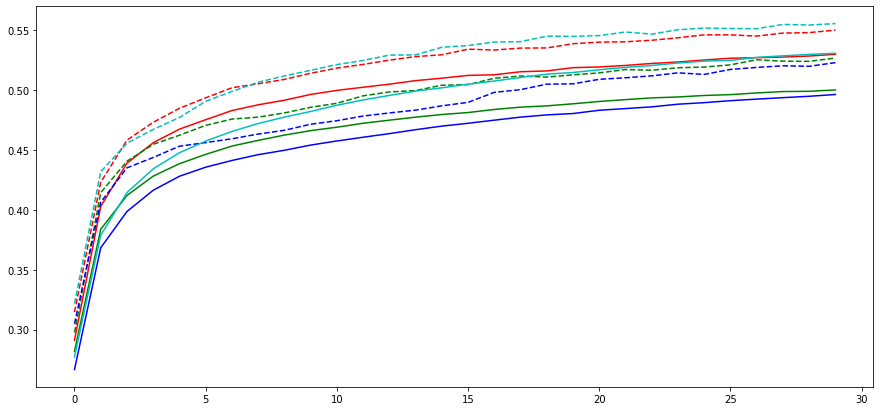

In [19]:
plt.figure(figsize=(15,7))
arr = np.array(max_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'r')
plt.plot(np.max(arr[:,0], axis=0), 'r--')
arr = np.array(frac_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'g')
plt.plot(np.max(arr[:,0], axis=0), 'g--')
arr = np.array(ft_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'b')
plt.plot(np.max(arr[:,0], axis=0), 'b--')
arr = np.array(avg_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'c')
plt.plot(np.max(arr[:,0], axis=0), 'c--')

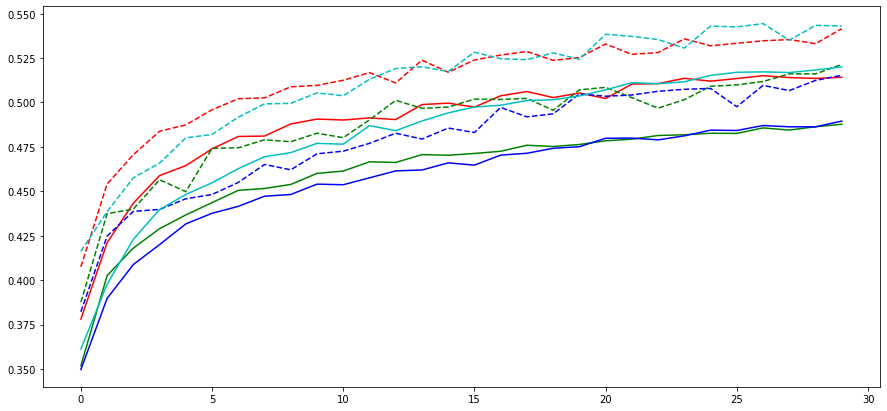

In [20]:
plt.figure(figsize=(15,7))
arr = np.array(max_net_h)
plt.plot(np.mean(arr[:,1], axis=0), 'r')
plt.plot(np.max(arr[:,1], axis=0), 'r--')
arr = np.array(frac_net_h)
plt.plot(np.mean(arr[:,1], axis=0), 'g')
plt.plot(np.max(arr[:,1], axis=0), 'g--')
arr = np.array(ft_net_h)
plt.plot(np.mean(arr[:,1], axis=0), 'b')
plt.plot(np.max(arr[:,1], axis=0), 'b--')
arr = np.array(avg_net_h)
plt.plot(np.mean(arr[:,1], axis=0), 'c')
plt.plot(np.max(arr[:,1], axis=0), 'c--')

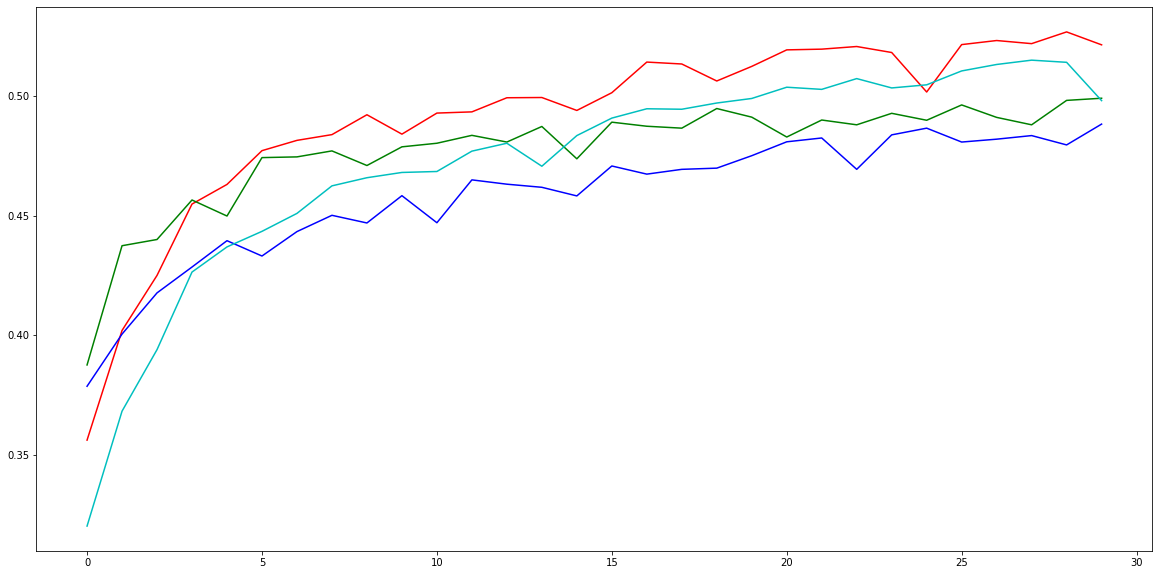

In [21]:
fig = plt.figure(figsize=(20,10))
plt.plot(max_net.get_history().history['val_accuracy'], 'r')
plt.plot(frac_net.get_history().history['val_accuracy'], 'g')
plt.plot(ft_net.get_history().history['val_accuracy'], 'b')
plt.plot(avg_net.get_history().history['val_accuracy'], 'c')
plt.show()
# petruv pristup